In [1]:
!pip install -q sagemaker-experiments

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
prefix = 'sagemaker-studio-book/chapter4'

In [126]:
from datetime import datetime, timedelta, timezone
import json, os, re, uuid
from time import sleep, gmtime, strftime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from botocore.exceptions import ClientError

from sagemaker import image_uris
from sagemaker.s3 import S3Uploader, S3Downloader
from sagemaker.inputs import TrainingInput

from sagemaker import clarify

In [4]:
orig_columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
              'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
              'hours-per-week', 'native-country', 'target']

df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
               names=orig_columns, sep=r'\s*,\s*', na_values='?', engine='python')
df_valtest=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
               names=orig_columns, skiprows=1, sep=r'\s*,\s*', na_values='?', engine='python')

df.drop(columns='education', inplace=True)
df_valtest.drop(columns='education', inplace=True)
df_valtest['target'] = df_valtest['target'].replace(to_replace=['<=50K.', '>50K.'], 
                                                    value=['<=50K', '>50K'])

# move the target column to first for XGBoost
new_columns=df.columns.tolist()
new_columns=[new_columns[-1]]+new_columns[:-1]
df=df[new_columns]
df_valtest=df_valtest[new_columns]

In [5]:
df.head()

,target,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [6]:
from sklearn import preprocessing

categorical_columns=df.select_dtypes(include='object').columns

encoder=preprocessing.OrdinalEncoder(dtype=int)
df[categorical_columns]=encoder.fit_transform(df[categorical_columns].fillna('NaN'))
df_valtest[categorical_columns]=encoder.transform(df_valtest[categorical_columns].fillna('NaN'))

After the ordinal encoding, the main features of interest are converted as below.
- sex: Male (1), Female (0)
- target: >50K (1), <=50K (0)

You can see the full mapping in `encoder.categories_`.

In [7]:
from sklearn.model_selection import train_test_split
df_val, df_test = train_test_split(df_valtest, test_size=0.9, random_state=42, 
                                   shuffle=True, stratify=df_valtest['target'])

In [8]:
df.shape, df_valtest.shape, df_val.shape, df_test.shape

((32561, 14), (16281, 14), (1628, 14), (14653, 14))

In [103]:
df['sex'].value_counts(sort=False)

0    10771
1    21790
Name: sex, dtype: int64

Text(0.5, 0, 'Sex (0: Female, 1: Male)')

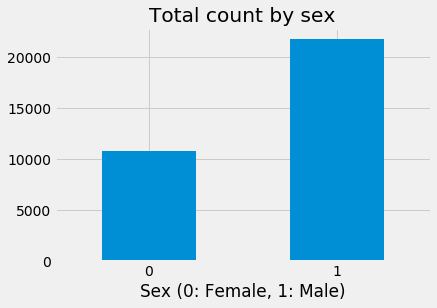

In [127]:
df['sex'].value_counts(sort=False).plot(kind='bar', title='Total count by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')

Text(0.5, 0, 'target (0: <=50K, 1: >50K)')

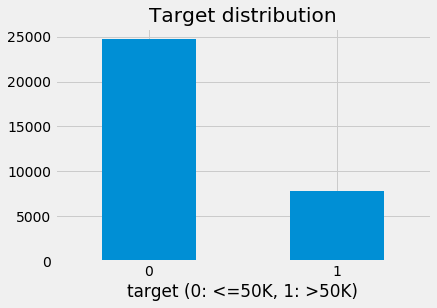

In [128]:
df['target'].value_counts(sort=False).plot(kind='bar', title='Target distribution', rot=0)
plt.xlabel('target (0: <=50K, 1: >50K)')

Text(0.5, 0, 'Sex (0: Female, 1: Male)')

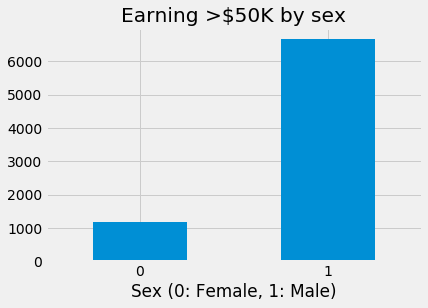

In [129]:
df[df['target']==1]['sex'].value_counts(sort=False).plot(
            kind='bar', title='Earning >$50K by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')

In [12]:
df.to_csv('adult/adult-data-train.csv', index=False, header=False)
df_val.to_csv('adult/adult-data-val.csv', index=False, header=False)

train_s3_uri = S3Uploader.upload('adult/adult-data-train.csv', 
                              f's3://{bucket}/{prefix}/adult-data')
val_s3_uri = S3Uploader.upload('adult/adult-data-val.csv', 
                            f's3://{bucket}/{prefix}/adult-data')
# df_test[columns_no_target].to_csv('adult/adult-data-testing.csv', index=False, header=False)

In [13]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
                                    role=role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge', 
                                    sagemaker_session=sess)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [14]:
experiment_name = 'adult-income-clarify'

try:
    experiment = Experiment.create(
        experiment_name=experiment_name, 
        description='Analyzing ML bias in adult income dataset using SageMaker Clarify.')
except ClientError as e:
    print(f'{experiment_name} experiment already exists! Reusing the existing experiment.')

In [15]:
# Creating a new trial for the experiment
exp_datetime_1 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

exp_trial_1 = Trial.create(experiment_name=experiment_name, 
                           trial_name=exp_datetime_1)

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_1.trial_name,
                   'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'}

In [16]:
pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_1.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df.columns.tolist(),
    dataset_type='text/csv',
)

In [17]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

In [18]:
jobname = f'adult-clarify-pretraining-bias-{exp_datetime_1}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker:Creating processing-job with name adult-clarify-pretraining-bias-2022-01-31-20-44-03



Job Name:  adult-clarify-pretraining-bias-2022-01-31-20-44-03
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-data/adult-data-train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-03/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify

## Review the bias in data

## Address the bias
1. Equal sample of Male vs Female, controlling race

In [19]:
max_female_sample=df.groupby(['sex', 'target'], 
                             group_keys=False).count().loc[(0, 1)]['age']

In [20]:
df_sampled=df.groupby(['sex', 'target'], 
                      group_keys=False).apply(lambda x: x.sample(max_female_sample))

In [21]:
df_sampled.shape

(4716, 14)

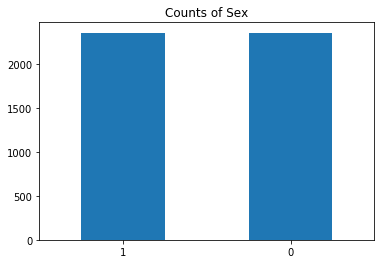

In [22]:
df_sampled['sex'].value_counts().sort_values().plot(kind='bar', 
                                                    title='Total count by sex', 
                                                    rot=0)

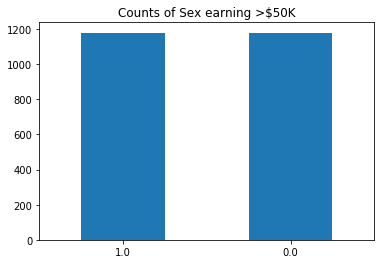

In [23]:
df_sampled['sex'].where(df_sampled['target'] == 1).value_counts().sort_values().plot(
    kind='bar', title='Earning >$50K by sex', rot=0)

In [24]:
df_sampled.to_csv('adult/adult-data-train-sampled.csv', index=False, header=False)
train_sampled_s3_uri = S3Uploader.upload('adult/adult-data-train-sampled.csv', 
                                      f's3://{bucket}/{prefix}/adult-data')

In [25]:
exp_datetime_2 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

# Creating a new trial for the experiment
exp_trial_2 = Trial.create(experiment_name=experiment_name, 
                         trial_name=exp_datetime_2)

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'}

pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])



jobname = f'adult-sampled-clarify-pretraining-bias-{exp_datetime_2}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-pretraining-bias-2022-01-31-20-44-05



Job Name:  adult-sampled-clarify-pretraining-bias-2022-01-31-20-44-05
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adul

## Training a ML model using XGBoost

In [26]:
exp_datetime_3 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-xgb-{exp_datetime_3}'

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Training'}

image = image_uris.retrieve(region=region, framework='xgboost', version='1.3-1')

train_s3_output = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/training'

xgb = sagemaker.estimator.Estimator(image,
                                    role,
                                    instance_type='ml.m5.xlarge',
                                    instance_count=1,
                                    output_path=train_s3_output,
                                    enable_sagemaker_metrics=True,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(objective='binary:logistic',
                        eval_metric='error',
                        num_round=50)

train_input = sagemaker.inputs.TrainingInput(s3_data=train_sampled_s3_uri, 
                                             content_type='csv')

val_input = sagemaker.inputs.TrainingInput(s3_data=val_s3_uri, 
                                             content_type='csv')

data_channels={'train': train_input, 'validation': val_input}

xgb.fit(inputs=data_channels, 
        job_name=jobname, 
        experiment_config=experiment_config, 
        wait=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: adult-xgb-2022-01-31-20-44-06


2022-01-31 20:44:06 Starting - Starting the training job...
2022-01-31 20:44:29 Starting - Launching requested ML instancesProfilerReport-1643661846: InProgress
......
2022-01-31 20:45:31 Starting - Preparing the instances for training.........
2022-01-31 20:46:51 Downloading - Downloading input data...
2022-01-31 20:47:37 Training - Training image download completed. Training in progress.
2022-01-31 20:47:37 Uploading - Uploading generated training model.[2022-01-31 20:47:33.418 ip-10-0-77-234.us-west-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-31:20:47:33:INFO] Imported framework sagemaker_xgboost_container.training
[2022-01-31:20:47:33:INFO] Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
[2022-01-31:20:47:33:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-01-31:20:47:33:INFO] No GPUs detected (normal if no gpus installed)
[2022-01-31:20:4

In [27]:
model_name = f'adult-xgb-model-{exp_datetime_3}'
model = xgb.create_model(name=model_name)

container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: adult-xgb-model-2022-01-31-20-44-06


'adult-xgb-model-2022-01-31-20-44-06'

In [36]:
experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-BiasAnalysis'}

posttraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-posttraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=posttraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

In [37]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

In [39]:
jobname = f'adult-sampled-clarify-posttraining-bias-{exp_datetime_3}'

clarify_processor.run_post_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    methods='all',    
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-bias-2022-01-31-20-44-06



Job Name:  adult-sampled-clarify-posttraining-bias-2022-01-31-20-44-06
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05/clarify-posttraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/ad

## Model explainability

In [60]:
df_sampled.median()

target                 0.5
age                   39.0
workclass              4.0
fnlwgt            176999.5
education-num         10.0
marital-status         2.0
occupation             7.0
relationship           1.0
race                   4.0
sex                    0.5
capital-gain           0.0
capital-loss           0.0
hours-per-week        40.0
native-country        39.0
dtype: float64

In [63]:
df_sampled.query('target == 1').median()

target                 1.0
age                   43.0
workclass              4.0
fnlwgt            173027.5
education-num         13.0
marital-status         2.0
occupation             7.0
relationship           1.0
race                   4.0
sex                    0.5
capital-gain           0.0
capital-loss           0.0
hours-per-week        40.0
native-country        39.0
dtype: float64

In [65]:
df_sampled.query('target == 1').mode().iloc[0, 1:].astype(int).tolist()

[39, 4, 111499, 13, 2, 10, 0, 4, 0, 0, 0, 40, 39]

In [31]:
experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-SHAP'}


explainability_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-explainability'

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=explainability_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

baseline = df_sampled.query('target == 1').mode().iloc[0, 1:].astype(int).tolist()
# baseline was df_test[new_columns[1:]].median().astype(int).tolist()
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=15,
    agg_method='mean_abs')


In [32]:
jobname = f'adult-sampled-clarify-posttraining-shap-{exp_datetime_2}'

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-shap-2022-01-31-20-44-05



Job Name:  adult-sampled-clarify-posttraining-shap-2022-01-31-20-44-05
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult

In [33]:
# experiment=Experiment.load(experiment_name)
# experiment.delete_all('--force')

In [45]:
explainability_output_path

's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05/clarify-explainability'

In [77]:
!aws s3 cp s3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-explainability/explanations_shap/out.csv .

download: s3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05/clarify-explainability/explanations_shap/out.csv to ./out.csv


In [80]:
print(f'{explainability_output_path}/explanations_shap/out.csv')

s3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05-2/clarify-explainability/explanations_shap/out.csv


In [81]:
!aws s3 ls s3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05-2/clarify-explainability/explanations_shap/out.csv

In [87]:
df_sampled.iloc[selected_example]

target                1
age                  42
workclass             5
fnlwgt            23510
education-num        14
marital-status        0
occupation            3
relationship          4
race                  1
sex                   1
capital-gain          0
capital-loss       2201
hours-per-week       60
native-country       18
Name: 20417, dtype: int64

Example number: 4714
with model prediction: True

Feature values: 
target                1
age                  42
workclass             5
fnlwgt            23510
education-num        14
marital-status        0
occupation            3
relationship          4
race                  1
sex                   1
capital-gain          0
capital-loss       2201
hours-per-week       60
native-country       18
Name: 20417, dtype: int64


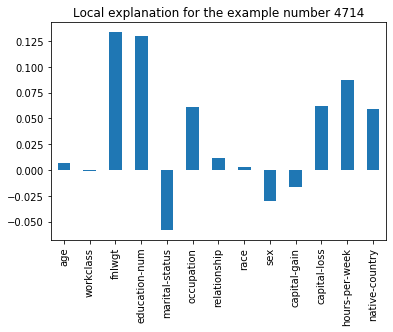

In [92]:
S3Downloader.download(f'{explainability_output_path}/explanations_shap/out.csv', 
                      './',
                      sagemaker_session=sess)
local_explanations_out = pd.read_csv('out.csv')
feature_names = [str.replace(c, '_label0', '') 
                 for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 4714
print(f'Example number: {selected_example}')
print(f'with model prediction: {sum(local_explanations_out.iloc[selected_example]) > 0}')
print()
print(f'Feature values: \n{df_sampled.iloc[selected_example]}')

local_explanations_out.iloc[selected_example].plot(
    kind='bar', 
    title=f'Local explanation for the example number {selected_example}', 
    rot=90)

In [94]:
local_explanations_out.shape

(4716, 13)

In [66]:
experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-SHAP-1'}


explainability_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}-1/clarify-explainability'

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=explainability_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

baseline = df_sampled.query('target == 1').mode().iloc[0, 1:].astype(int).tolist()
# baseline was df_test[new_columns[1:]].median().astype(int).tolist()
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=15,
    agg_method='mean_abs')


In [67]:
jobname = f'adult-sampled-clarify-posttraining-shap-{exp_datetime_2}-1'

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-shap-2022-01-31-20-44-05-1



Job Name:  adult-sampled-clarify-posttraining-shap-2022-01-31-20-44-05-1
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05-1/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/a

In [72]:
df_sampled.sample(n=50).values[:, 1:].tolist()

[[43, 4, 117037, 7, 2, 14, 0, 4, 1, 0, 2042, 40, 39],
 [35, 4, 174597, 13, 2, 2, 0, 4, 1, 0, 0, 40, 39],
 [50, 4, 65408, 9, 2, 2, 0, 4, 1, 0, 0, 50, 39],
 [28, 4, 191088, 13, 2, 3, 5, 4, 0, 0, 0, 40, 39],
 [39, 4, 352248, 12, 2, 0, 0, 4, 1, 0, 0, 40, 39],
 [23, 4, 250037, 10, 4, 4, 1, 4, 0, 0, 0, 50, 39],
 [31, 4, 181091, 9, 2, 2, 0, 4, 1, 0, 0, 50, 39],
 [32, 6, 420895, 13, 2, 12, 0, 4, 1, 0, 0, 47, 39],
 [77, 6, 72931, 4, 3, 0, 1, 4, 1, 0, 0, 20, 21],
 [21, 4, 212619, 11, 4, 6, 3, 4, 1, 0, 0, 40, 39],
 [78, 6, 82815, 10, 2, 2, 0, 4, 1, 0, 0, 3, 39],
 [42, 5, 90693, 13, 2, 3, 0, 4, 1, 0, 0, 70, 39],
 [52, 4, 204584, 13, 3, 3, 1, 4, 0, 0, 0, 42, 39],
 [45, 4, 339506, 9, 4, 12, 1, 2, 1, 0, 0, 40, 39],
 [23, 4, 340543, 13, 4, 3, 1, 4, 0, 0, 0, 38, 39],
 [35, 4, 175614, 11, 0, 10, 4, 4, 0, 0, 0, 40, 39],
 [28, 4, 335357, 9, 4, 5, 3, 2, 1, 0, 0, 40, 39],
 [51, 4, 243361, 10, 6, 0, 4, 4, 0, 0, 0, 45, 39],
 [52, 0, 424012, 10, 0, 3, 1, 4, 0, 0, 0, 40, 39],
 [33, 4, 117983, 9, 4, 0, 1, 4, 0, 

In [75]:
experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-SHAP-2'}


explainability_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}-2/clarify-explainability'

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=explainability_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

baseline = df_sampled.sample(n=50).values[:, 1:].tolist()
# baseline was df_test[new_columns[1:]].median().astype(int).tolist()
shap_config = clarify.SHAPConfig(
    baseline=baseline,
    num_samples=200,
    agg_method='mean_abs')


In [76]:
jobname = f'adult-sampled-clarify-posttraining-shap-{exp_datetime_2}-2-1'

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False
)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-shap-2022-01-31-20-44-05-2-1



Job Name:  adult-sampled-clarify-posttraining-shap-2022-01-31-20-44-05-2-1
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4/adult-income-clarify-2022-01-31-20-44-05-2/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-552106442228/sagemaker-studio-book/chapter4